In [1]:
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, accuracy_score, precision_score, recall_score
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

from google.colab import drive
drive.mount('/content/drive')

# Define the path to the directory containing the feature files
directory_path = '/content/drive/MyDrive/FYP_dataset/features'

# Get a list of all feature file paths in the directory
feature_files = glob.glob(directory_path + '/*.csv')

# Define lists to store the feature and target data
X = []
y_v = []

# Iterate over each feature file
for file in feature_files:
    # Read the feature file into a DataFrame
    df = pd.read_csv(file)

    # Extract the features and target variables
    features = df.drop(['Arousal_Value', 'Valence_Value', 'frameTime'], axis=1).values
    valence = df['Valence_Value'].values

    # Append the data to the lists
    X.append(features)
    y_v.append(valence)

# Concatenate the feature and target arrays
X = np.concatenate(X)
y_v = np.concatenate(y_v)

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the input data for LSTM
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize lists to store evaluation results for Valence
mse_v = []
mae_v = []
rmse_v = []
r2_v = []
f1_v = []
accuracy_v = []
precision_v = []
recall_v = []

# Perform tenfold cross-validation for Valence
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_reshaped):
    X_train, X_val = X_reshaped[train_index], X_reshaped[test_index]
    y_v_train, y_v_val = y_v[train_index], y_v[test_index]

    # Split the validation set further into val and test sets
    val_size = len(X_val) // 2
    X_val, X_test = X_val[:val_size], X_val[val_size:]
    y_v_val, y_v_test = y_v_val[:val_size], y_v_val[val_size:]

    # Build the BiLSTM model for Valence
    model_v = Sequential()
    model_v.add(Bidirectional(CuDNNLSTM(64, return_sequences=True), input_shape=(X_train.shape[1], 1)))
    model_v.add(Flatten())

    # Add DNN layers with dropout for Valence
    dnn_layers_v = [512, 256,128,64]  # Modify this list as needed

    for layer_size in dnn_layers_v:
        model_v.add(Dense(layer_size, activation='relu'))


    model_v.add(Dense(1))
    model_v.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

    # Train the Valence model
    model_v.fit(X_train, y_v_train, validation_data=(X_val, y_v_val), epochs=25, batch_size=32)

    # Evaluate the model on the test set for Valence
    predictions_v = model_v.predict(X_test)

    # Reshape predictions_v to match the shape of y_v_test
    predictions_v = predictions_v.reshape(y_v_test.shape)

    # Calculate additional evaluation metrics for Valence
    mse_v.append(mean_squared_error(y_v_test, predictions_v))
    mae_v.append(mean_absolute_error(y_v_test, predictions_v))
    rmse_v.append(np.sqrt(mean_squared_error(y_v_test, predictions_v)))
    r2_v.append(r2_score(y_v_test, predictions_v))

    # Convert regression predictions to binary labels for Valence
    threshold = 0
    binary_predictions_v = (predictions_v >= threshold).astype(int)
    y_v_test_binary = (y_v_test >= threshold).astype(int)

    # Calculate F1-score, accuracy, precision, and recall for binary classification for Valence
    f1_v.append(f1_score(y_v_test_binary, binary_predictions_v))
    accuracy_v.append(accuracy_score(y_v_test_binary, binary_predictions_v))
    precision_v.append(precision_score(y_v_test_binary, binary_predictions_v))
    recall_v.append(recall_score(y_v_test_binary, binary_predictions_v))

# Calculate average performance across all folds for Valence
average_mse_v = np.mean(mse_v)
average_mae_v = np.mean(mae_v)
average_rmse_v = np.mean(rmse_v)
average_r2_v = np.mean(r2_v)
average_f1_v = np.mean(f1_v)
average_accuracy_v = np.mean(accuracy_v)
average_precision_v = np.mean(precision_v)
average_recall_v = np.mean(recall_v)

print("\nValence Results:")
print(f'Average Valence MSE: {average_mse_v:.4f}')
print(f'Average Valence MAE: {average_mae_v:.4f}')
print(f'Average Valence RMSE: {average_rmse_v:.4f}')
print(f'Average Valence R2 Score: {average_r2_v:.4f}')
print(f'Average Valence F1 Score: {average_f1_v:.4f}')
print(f'Average Valence Accuracy: {average_accuracy_v:.4f}')
print(f'Average Valence Precision: {average_precision_v:.4f}')
print(f'Average Valence Recall: {average_recall_v:.4f}')


Mounted at /content/drive
Epoch 1/25
2654/2654 [==============================] - 68s 22ms/step - loss: 0.0433 - val_loss: 0.0424
Epoch 2/25
2654/2654 [==============================] - 57s 22ms/step - loss: 0.0391 - val_loss: 0.0420
Epoch 3/25
2654/2654 [==============================] - 57s 22ms/step - loss: 0.0376 - val_loss: 0.0404
Epoch 4/25
2654/2654 [==============================] - 57s 22ms/step - loss: 0.0365 - val_loss: 0.0393
Epoch 5/25
2654/2654 [==============================] - 58s 22ms/step - loss: 0.0354 - val_loss: 0.0379
Epoch 6/25
2654/2654 [==============================] - 57s 22ms/step - loss: 0.0347 - val_loss: 0.0371
Epoch 7/25
2654/2654 [==============================] - 58s 22ms/step - loss: 0.0339 - val_loss: 0.0372
Epoch 8/25
2654/2654 [==============================] - 57s 21ms/step - loss: 0.0332 - val_loss: 0.0362
Epoch 9/25
2654/2654 [==============================] - 57s 21ms/step - loss: 0.0329 - val_loss: 0.0366
Epoch 10/25
2654/2654 [===============

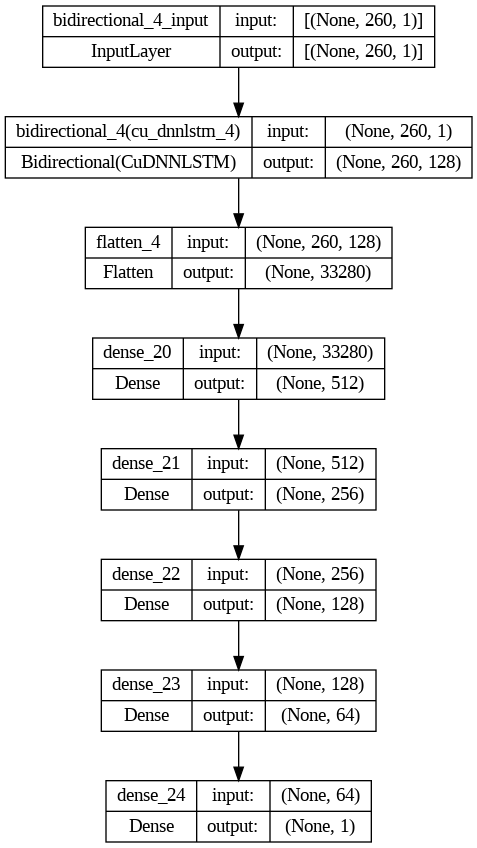

In [2]:
from tensorflow.keras.utils import plot_model


# Save the model diagram as an image
plot_model(model_v, to_file='model_v.png', show_shapes=True, show_layer_names=True)